In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

In [4]:
train_data = pd.read_csv('dataset/Train.csv')
print("Shape of train_data:", train_data.shape)

Shape of train_data: (42000, 785)


In [5]:
train_data.head(3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


as you see most of columns are 0 because of pixel values
there are 785 columns because images are 28x28 size. + label col.

In [6]:
X = train_data.iloc[:, 1:]  
y = train_data.iloc[:, 0]   

print("Shape of X after separating features:", X.shape)
print("Shape of y after separating features:", y.shape)

Shape of X after separating features: (42000, 784)
Shape of y after separating features: (42000,)


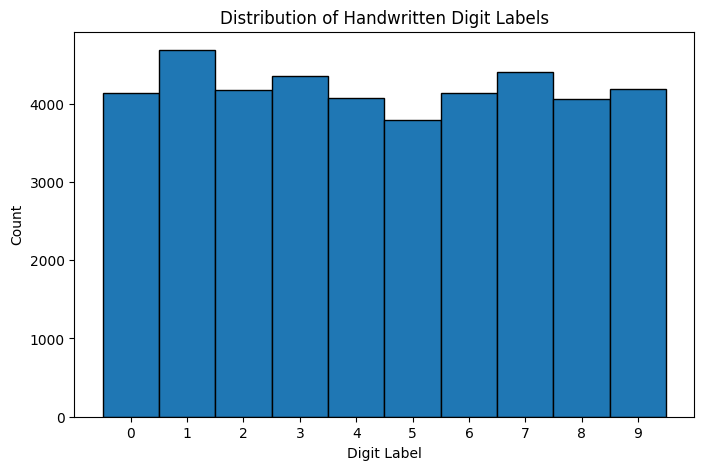

In [7]:
plt.figure(figsize=(8, 5))
plt.hist(y, bins=np.arange(11) - 0.5, edgecolor='black')  # bins from -0.5 to 9.5
plt.xticks(range(10))
plt.xlabel("Digit Label")
plt.ylabel("Count")
plt.title("Distribution of Handwritten Digit Labels")
plt.show()


This will give you a histogram showing how balanced (or imbalanced) the digits are across your dataset.

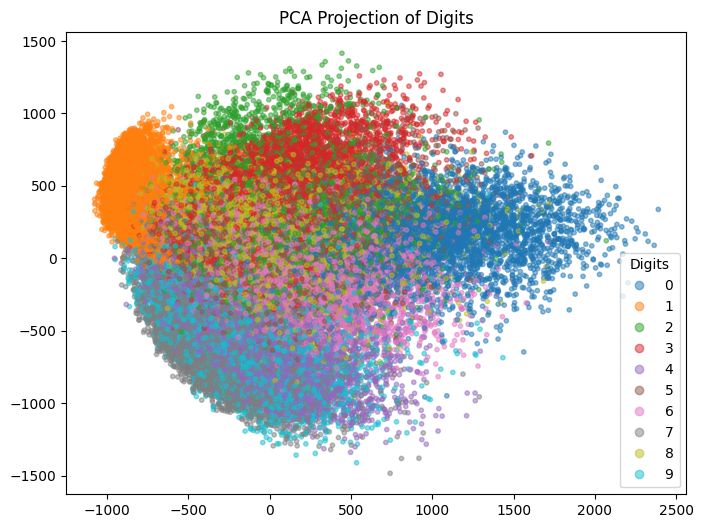

In [8]:
# Reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="tab10", alpha=0.5, s=10)
plt.legend(*scatter.legend_elements(), title="Digits")
plt.title("PCA Projection of Digits")
plt.show()


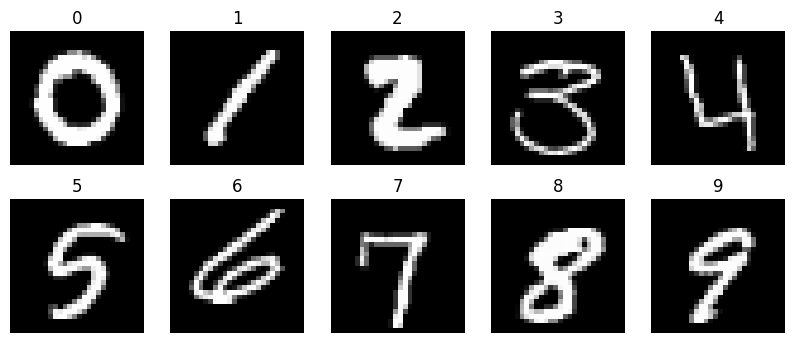

In [9]:
X = train_data.iloc[:, 1:].values  # convert to NumPy array
y = train_data.iloc[:, 0].values

#Sample per Class
plt.figure(figsize=(10,4))
for digit in range(10):
    idx = np.where(y == digit)[0][0]  # first sample of this digit
    plt.subplot(2,5,digit+1)
    plt.imshow(X[idx].reshape(28,28), cmap="gray")
    plt.title(f"{digit}")
    plt.axis("off")
plt.show()

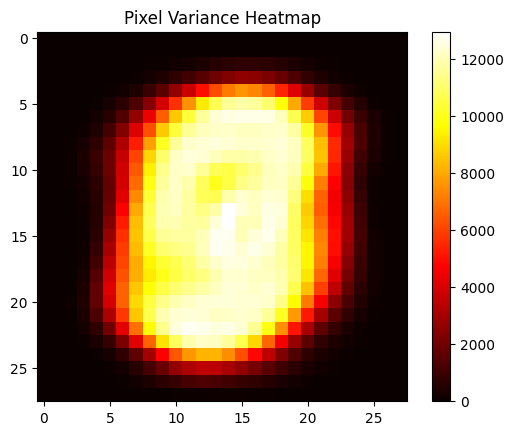

In [10]:
pixel_var = X.var(axis=0).reshape(28,28)
plt.imshow(pixel_var, cmap='hot')
plt.colorbar()
plt.title("Pixel Variance Heatmap")
plt.show()


d:\handwritten\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
d:\handwritten\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


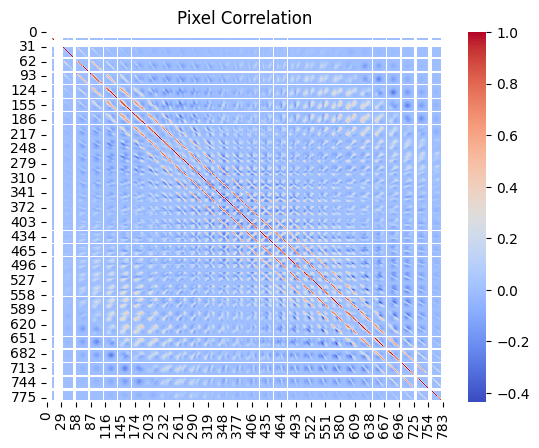

In [11]:
# Compute correlation on a subset for speed
subset_pixels = X[:, :]
corr = np.corrcoef(subset_pixels.T)
sns.heatmap(corr, cmap='coolwarm')
plt.title("Pixel Correlation")
plt.show()


In [12]:
if not isinstance(X, pd.DataFrame):
    X = pd.DataFrame(X)
X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(0)  
X = X.values / 255.0
X = X.reshape(-1, 28, 28, 1)
print("Shape of X after reshaping:", X.shape)

Shape of X after reshaping: (42000, 28, 28, 1)


First we ensure X is in the correct format (Pandas DataFrame).
Then we convert all pixel values to numeric format and replace any missing values with 0.
Next we normalize the pixel values to the range [0, 1] by dividing them by 255.0. This helps the model learn faster.
Finally we reshape the data to include a channel dimension making it compatible with neural networks.

In [13]:
y = to_categorical(y, num_classes=10)
print("Shape of y after one-hot encoding:", y.shape)

Shape of y after one-hot encoding: (42000, 10)


A classifier usually outputs a vector of probabilities for each class (via softmax).

Example: [0.01, 0.02, 0.05, 0.9, ..., 0.01] → probability of each digit.

To compute loss, you need the true labels in the same shape

In [14]:
#train test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape) # row, high,width, channel(grey or RGB)

X_train shape: (33600, 28, 28, 1)


In [15]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

d:\handwritten\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

Layer	Shape	Purpose
Input	(28,28,1)	Accept grayscale images
Flatten	(784,)	Convert 2D image to feature vector
Dense(128, relu)	(128,)	Learn low-level features (strokes, edges)
Dense(64, relu)	(64,)	Learn higher-level patterns (digit shapes)
Dense(10, softmax)	(10,)	Output probability of each digit

In [16]:
#train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.9450 - loss: 0.1813 - val_accuracy: 0.9762 - val_loss: 0.0753
Epoch 2/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9831 - loss: 0.0553 - val_accuracy: 0.9812 - val_loss: 0.0578
Epoch 3/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9888 - loss: 0.0367 - val_accuracy: 0.9840 - val_loss: 0.0557
Epoch 4/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9913 - loss: 0.0273 - val_accuracy: 0.9871 - val_loss: 0.0374
Epoch 5/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9941 - loss: 0.0193 - val_accuracy: 0.9877 - val_loss: 0.0380
Epoch 6/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.9948 - loss: 0.0163 - val_accuracy: 0.9865 - val_loss: 0.0449
Epoch 7/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9962 - loss: 0.0120 - val_accuracy: 0.9904 - val_loss: 0.0322
Epoch 8/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9965 -

263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9896 - loss: 0.0430
Validation Accuracy: 98.96%


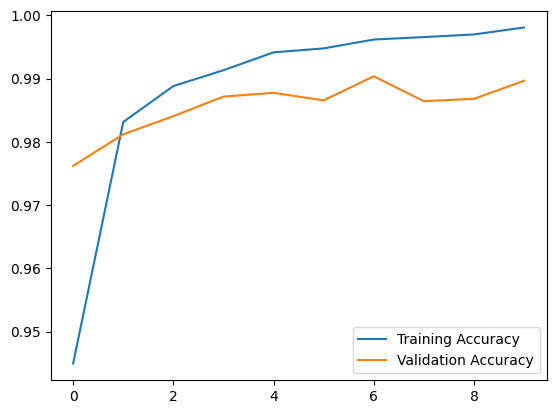

In [17]:
#Evaluate model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


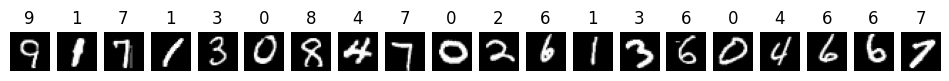

In [32]:
#test with test dataset
test_data = pd.read_csv('dataset/test.csv')
X_test = test_data.values / 255.0
X_test = X_test.reshape(-1, 28, 28, 1)
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
plt.figure(figsize=(12,3))
for i in range(20):
    plt.subplot(2,20,i+1)
    plt.imshow(X_test[i].reshape(28,28), cmap='gray')
    plt.title(predicted_labels[i])
    plt.axis('off')
plt.show()

    
    

In [ ]:
loss, acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {acc*100:.2f}%")

263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9896 - loss: 0.0430
Validation Accuracy: 98.96%


263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


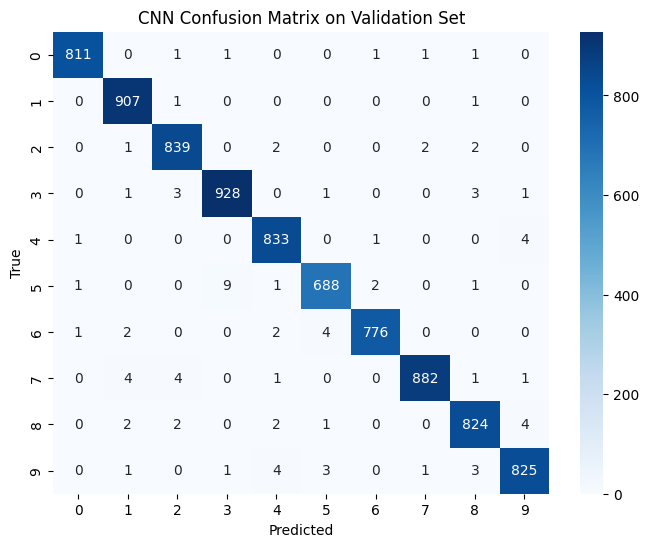

In [28]:
from sklearn.metrics import confusion_matrix
# Predicted labels
y_val_labels = np.argmax(y_val, axis=1)
predicted_labels = np.argmax(model.predict(X_val), axis=1)

# Confusion matrix
cm = confusion_matrix(y_val_labels, predicted_labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("CNN Confusion Matrix on Validation Set")
plt.show()


In [30]:
from sklearn.metrics import classification_report

# True labels from validation set
y_true = np.argmax(y_val, axis=1)

# Predicted labels
y_pred = np.argmax(model.predict(X_val), axis=1)

# Generate classification report
report = classification_report(y_true, y_pred, digits=4)
print(report)


263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

           0     0.9963    0.9939    0.9951       816
           1     0.9880    0.9978    0.9929       909
           2     0.9871    0.9917    0.9894       846
           3     0.9883    0.9904    0.9893       937
           4     0.9858    0.9928    0.9893       839
           5     0.9871    0.9801    0.9836       702
           6     0.9949    0.9885    0.9917       785
           7     0.9955    0.9877    0.9916       893
           8     0.9856    0.9868    0.9862       835
           9     0.9880    0.9845    0.9863       838

    accuracy                         0.9896      8400
   macro avg     0.9897    0.9894    0.9895      8400
weighted avg     0.9897    0.9896    0.9896      8400



In [31]:
# Save model
model.save("handwritten_cnn.keras")
